# MN-RSA derivation and example

$$
\DeclareMathOperator{\Tr}{Tr}
\newcommand{\trp}{{^\T}} % transpose
\newcommand{\trace}{\text{Trace}} % trace
\newcommand{\inv}{^{-1}}
\newcommand{\mb}{\mathbf{b}}
\newcommand{\M}{\mathbf{M}}
\newcommand{\G}{\mathbf{G}}
\newcommand{\A}{\mathbf{A}}
\newcommand{\R}{\mathbf{R}}
\renewcommand{\S}{\mathbf{S}}
\newcommand{\B}{\mathbf{B}}
\newcommand{\Q}{\mathbf{Q}}
\newcommand{\mH}{\mathbf{H}}
\newcommand{\U}{\mathbf{U}}
\newcommand{\mL}{\mathbf{L}}
\newcommand{\diag}{\mathrm{diag}}
\newcommand{\etr}{\mathrm{etr}}
\renewcommand{\H}{\mathbf{H}}
\newcommand{\vecop}{\mathrm{vec}}
\newcommand{\I}{\mathbf{I}}
\newcommand{\X}{\mathbf{X}}
\newcommand{\Y}{\mathbf{Y}}
\newcommand{\Z}{\mathbf{Z}}
\renewcommand{\L}{\mathbf{L}}
$$

We write the generative model for beta-series RSA. Note that for indicator-coded design matrix $\X$ this is exactly equivalent to reshaping your data and directly computing the correlation, but allows for other features like convolving $\X$ with an HRF. Here is the model: 

$$
\Y = \X\beta + \epsilon
$$

where $\Y$ is a TRs-by-voxels matrix of fMRI data, $\X$ is a timepoint-by-feature design matrix that usually identifies conditions in the experiment, $\beta$ is a feature-by-voxel matrix, $\epsilon$ is a matrix of random perturbations (i.e. the noise). In conventional correlation-based RSA $\epsilon \sim \mathcal{N}(0, \sigma^2 \I)$, i.e. the distribution of residulas is i.i.d. In Cai et al's BRSA $\epsilon$ has temporal AR(1) noise structure and voxel-specific noise variance. Of research interest is the covariance of $\beta$ in its row dimension, so we want to estimate as little as possible of anything else. We additionally import from Cai et al.'s BRSA the use of $\X_0$, an unmodeled latent timecourse projected onto voxels by $\beta_0$ as a way of capturing additional residual structure. 

The above model can be written as follows: 

$$
\Y\mid\beta,\X_0,\beta_0,\Sigma_t,\sigma_s  \sim\mathcal{MN}(\X\beta+\X_0\beta_0, \Sigma_t, \sigma_s\trp\mathbf{I}),
$$

where $\Sigma_t$ is a covariance matrix for the AR(1) covariance ($\A\inv$ in the BRSA paper), and $\sigma_s$ is a spatial noise scaler that allows each voxel to have its own noise. This is not as general as voxel-specific AR coefficients, but has far fewer parameters and will allow us to tractably handle more complex temporal covariances. This tradeoff will behave differently in different datasets. 

Now we add a matrix-normal prior on $\beta$, allowing us to marginalize. We parameterize the covariance in terms of its cholesky factor $\L$. 

$$
\beta\sim\mathcal{MN}(0,\L\L\trp, \sigma_s\trp\I)\\
\Y\mid\X_0,\beta_0,\Sigma_t,\sigma_s  \sim\mathcal{MN}(\X_0\beta_0, \Sigma_t + \X\L\L\trp\X\trp ,  \vec{\sigma_s}\trp\mathbf{I})\\
$$

Using the same identity, we can marginalize over $\beta_0$. 

$$
\beta_0\sim\mathcal{MN}(0,\I, \sigma_s\I)\\
\Y\mid\X_0,\beta_0,\Sigma_t,\sigma_s  \sim\mathcal{MN}(0, \Sigma_t + \X\L\L\trp\X\trp + \X_0\X_0\trp , \sigma_s\mathbf{I})
$$

Now, the temporal covariance is the sum of an autoregressive term, a low-rank noise term, and our term of interest. 

Next, we apply some computational tricks. Consider the matrix normal (log) density: 

$$
P(X; M, U, V) = \frac{\exp\left(-\frac12\Tr\left[V\inv(X-M)\trp U\inv(X-M)\right]\right)}{(2\pi)^{np/2}|U|^{p/2}|V|^{n/2}}\\
2 \log P(X; M, U, V) = -\Tr\left[V\inv(X-M)\trp U\inv(X-M)\right]-np\log 2\pi-p\log|U|-n\log|V|
$$

Here $n$ and $p$ are the row and column dimension of $M$. Note that both the determinant and the inverse are $O(n^3)$ and $O(p^3)$ for the two covariances. Furthermore, computing the determinant and logging it will be unstable. So instead we can take the cholesky decomposition of both covariances, at which point the log-determinant is just 2 times the sum of the diagonal elements. Then, we recognize that the term inside of the trace can be computed by our favorite triangular matrix solver using the cholesky we already paid for. Let $A = V, B = (X-M)\trp$. Then a solver for X in $AX=B$ will give us exactly $V^{-1}(X-M)\trp$. We play the same exact trick for $A=U, B=(X-M)$ (though of course we center the brain first so $M=0$. 

Cai et al. additionally apply the matrix inversion lemma twice so that they invert something feature-by-feature instead of time-by-time. Doing this naively will not help us in this version because we're still stuck with doing the determinant (which is cubic in time). Here is the expression: 

$$
\begin{aligned}
\Sigma_Y :=& \Sigma_t + \X\L\L\trp\X\trp + \X_0\X_0\trp \\
\mbox{let } \Z :=&  \Sigma_t + \X\L\L\trp\X\trp\\
\Sigma_Y\inv =& (\Z + \X_0\X_0\trp)\inv \\
=& \Z\inv - \Z\inv\X_0(\I + \X_0\trp\Z\inv\X_0)\inv\X_0\trp\Z\inv\\
\Z\inv =& \Sigma_t\inv - \Sigma_t\inv \X\L(\I+\L\trp\X\trp\Sigma_t\inv\L\X)\inv\L\trp\X\trp \Sigma_t\inv\\
\end{aligned}
$$

That said, if the inverse and determinant of $\Sigma_t\inv$ is trivial (as in the case of AR1 but not generally), we can apply the matrix determinant lemma:

$$
\begin{aligned}
\Sigma_Y :=& \Sigma_t + \X\L\L\trp\X\trp + \X_0\X_0\trp \\
\mbox{let } \Z :=&  \Sigma_t + \X\L\L\trp\X\trp\\
|\Sigma_Y| =& |\Z + \X_0\X_0\trp| \\
=& |\Z|\times|\I + \X_0\trp\Z\inv\X_0|\\
\Z\inv =& \Sigma_t\inv - \Sigma_t\inv \X\L(\I+\L\trp\X\trp\Sigma_t\inv\X\L)\inv\L\trp\X\trp \Sigma_t\inv\\
|\Z| =& |\Sigma_t| \times|\I+\L\trp\X\trp\Sigma_t\inv\X\L|\\
=& \frac{|\I+\L\trp\X\trp\Sigma_t\inv\X\L|}{|\Sigma_t\inv|} \\
\end{aligned}
$$

Now we notice that we can still apply our cholesky-inverse-solve trick because the term in the inverse and determinant with the lemmas applied is identical. As long as the inverse and determinant of the temporal noise covariance is computable in better than cubic time, this is useful to do. Currently the lemma trick is not being done in the code (but the cholesky trick is). 

Now here is an example: 

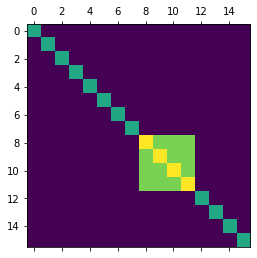

In [1]:
import scipy
from scipy.stats import norm
from scipy.special import expit as inv_logit
import numpy as np
from numpy.linalg import cholesky
import matplotlib.pyplot as plt


def rmn(rowcov, colcov):
    # generate random draws from a zero-mean matrix-normal distribution
    Z = norm.rvs(norm.rvs(size=(rowcov.shape[0], colcov.shape[0])))
    return cholesky(rowcov).dot(Z).dot(cholesky(colcov))


def make_ar1_with_lowrank_covmat(size, rank):
    """ Generate a random covariance that is AR1 with added low rank structure
    """
    sigma = np.abs(norm.rvs())
    rho = np.random.uniform(-1, 0)
    offdiag_template = scipy.linalg.toeplitz(np.r_[0, 1, np.zeros(size - 2)])
    diag_template = np.diag(np.r_[0, np.ones(size - 2), 0])
    I = np.eye(size)

    prec_matrix = (I - rho * offdiag_template + rho ** 2 * diag_template) / (sigma ** 2)
    lowrank_matrix = norm.rvs(size=(size, rank))
    return np.linalg.inv(prec_matrix) + lowrank_matrix.dot(lowrank_matrix.T)


def gen_data(n_T, n_V, space_cov, time_cov):

    n_C = 16
    U = np.zeros([n_C, n_C])
    U = np.eye(n_C) * 0.6
    U[8:12, 8:12] = 0.8
    for cond in range(8, 12):
        U[cond, cond] = 1

    beta = rmn(U, space_cov)

    X = rmn(np.eye(n_T), np.eye(n_C))

    Y_hat = X.dot(beta)

    Y = Y_hat + rmn(time_cov, space_cov)

    return beta, X, Y, U


n_T = 100
n_V = 80
n_C = 16

spacecov_true = np.diag(np.abs(norm.rvs(size=(n_V))))
timecov_true = make_ar1_with_lowrank_covmat(n_T, rank=7)

true_beta, true_X, true_Y, true_U = gen_data(n_T, n_V, spacecov_true, timecov_true)

%matplotlib inline
plt.matshow(true_U)

That is the target matrix. Now we noisify it using a simple synthetic brain data generator, and recover it with MN-RSA. We intentionally code up MN-RSA here from the building blocks the toolkit provides so we can illustrate how easy it is to build new models: 

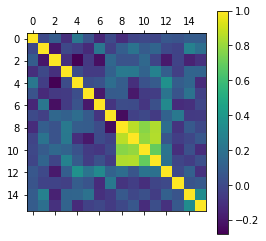

In [2]:
import tensorflow as tf
from brainiak.matnormal.covs import CovDiagonal, CovAR1, CovUnconstrainedCholesky
from brainiak.utils.utils import cov2corr
from brainiak.matnormal.utils import (
    make_val_and_grad,
    pack_trainable_vars,
    unpack_trainable_vars,
    unflatten_cholesky_unique,
)
from brainiak.matnormal.matnormal_likelihoods import matnorm_logp_marginal_row
from scipy.optimize import minimize

space_cov = CovDiagonal(size=n_V)
time_cov = CovAR1(size=n_T)

rsa_cov = CovUnconstrainedCholesky(size=n_C)

params = (
    rsa_cov.get_optimize_vars()
    + time_cov.get_optimize_vars()
    + space_cov.get_optimize_vars()
)

# construct loss (marginal likelihood constructed automatically)
# note that params are ignored by this function but implicitly
# tracked by tf.GradientTape, and the remaining inputs are
# embedded via the closure mechanism
def loss(params):
    return -(
        time_cov.logp
        + space_cov.logp
        + rsa_cov.logp
        + matnorm_logp_marginal_row(
            true_Y, row_cov=time_cov, col_cov=space_cov, marg=true_X, marg_cov=rsa_cov
        )
    )


val_and_grad = make_val_and_grad(lossfn=loss, train_vars=params)

x0 = pack_trainable_vars(params)

opt_results = minimize(fun=val_and_grad, x0=x0, jac=True, method="L-BFGS-B")

fit_params = unpack_trainable_vars(opt_results.x, params)

for var, val in zip(params, fit_params):
    var.assign(val)

U = rsa_cov._cov.numpy()
C = cov2corr(U)
plt.matshow(C)
plt.colorbar()

In practice, MN-RSA is already implemented in brainiak.matnormal, including the nuisance regressor estimation of Cai et al.

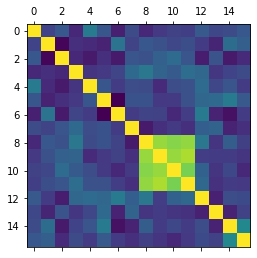

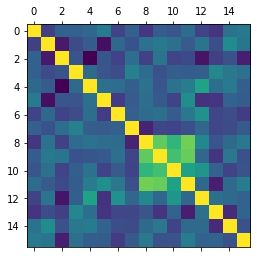

In [3]:
from brainiak.matnormal.mnrsa import MNRSA
from brainiak.matnormal.covs import CovIdentity
from sklearn.linear_model import LinearRegression

# beta_series RSA
model_linreg = LinearRegression(fit_intercept=False)
model_linreg.fit(true_X, true_Y)
beta_series = model_linreg.coef_
naive_RSA = np.corrcoef(beta_series.T)

# MN-RSA
space_cov = CovDiagonal(size=n_V)
time_cov = CovAR1(size=n_T)

model_matnorm = MNRSA(time_cov=time_cov, space_cov=space_cov, n_nureg=3)

model_matnorm.fit(true_Y, true_X)

# very similar on this toy data but as we show in the paper can be very different
# in other examples
plt.matshow(model_matnorm.C_)
plt.matshow(naive_RSA)